In [1]:
run_best_model = False
compute_best_model = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy import stats


from datetime import datetime as dt
from pprint import pprint


from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn import svm
from sklearn import metrics
from sklearn.svm import LinearSVC




# import warnings
# warnings.filterwarnings('ignore')
# import tensorflow as tf
# tf.get_logger().setLevel('INFO')
# tf.logging.set_verbosity(tf.logging.ERROR)

# import keras
# from keras.models import Model
# from keras.layers import Input, Dense, Dropout

In [3]:
df = pd.read_csv('Data/temp_population_case.csv')
df.head(5)

,Date,Confirmed,Confirmed_Log,Increase,Prior_Day_Increase,Moving_Average_Case,Next_7_day_Moving_Average_Case,Next_3_day_Moving_Average_Case,Moving_Sum_Case,Next_7_day_Moving_Sum_Case,...,Temp_3_Day,Temp_Week,Temp_2_Week,Humidity_3_Day,Humidity_Week,Humidity_2_Week,Population,Area,Pop_Density,Weekday
0,3/13/20,5,1.609438,5.0,0.0,0.714286,1.000000,2.333333,5.0,7.0,...,22.333333,20.000000,19.571429,86.666667,78.000000,77.357143,4903185,52423,93.531179,4
1,3/14/20,7,1.945910,2.0,5.0,1.000000,1.571429,3.666667,7.0,11.0,...,22.666667,21.000000,20.000000,86.000000,82.285714,78.928571,4903185,52423,93.531179,5
2,3/15/20,11,2.397895,4.0,2.0,1.571429,4.142857,8.000000,11.0,29.0,...,24.000000,22.285714,20.571429,82.000000,83.285714,79.428571,4903185,52423,93.531179,6
3,3/16/20,29,3.367296,18.0,4.0,4.142857,5.571429,10.666667,29.0,39.0,...,24.000000,22.857143,20.785714,80.666667,83.571429,79.500000,4903185,52423,93.531179,0
4,3/17/20,39,3.663562,10.0,18.0,5.571429,7.285714,13.333333,39.0,51.0,...,24.000000,23.142857,20.857143,81.666667,83.857143,79.357143,4903185,52423,93.531179,1


In [4]:
df.columns

Index(['Date', 'Confirmed', 'Confirmed_Log', 'Increase', 'Prior_Day_Increase',
       'Moving_Average_Case', 'Next_7_day_Moving_Average_Case',
       'Next_3_day_Moving_Average_Case', 'Moving_Sum_Case',
       'Next_7_day_Moving_Sum_Case', 'Next_3_day_Moving_Sum_Case', 'HeatIndex',
       'Humidity', 'Temperatue', 'Windspeed', 'State', 'Temp_3_Day',
       'Temp_Week', 'Temp_2_Week', 'Humidity_3_Day', 'Humidity_Week',
       'Humidity_2_Week', 'Population', 'Area', 'Pop_Density', 'Weekday'],
      dtype='object')

In [5]:
len(df.State.unique())
# df.State.unique()

51

In [6]:
df.State.unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [7]:
# df['State_Code'] = df.State.apply(lambda state: 1 if state in ['New York', 'New Jersey'] else 2)
# df['State_Code'] = df.State_Code.astype('category').cat.codes

In [8]:
df['sa'] = df.State.apply(lambda state: 'Severe_State' if state in ['New York', 'New Jersey', 'Illinois'] else 'Normal_State')
State_Code = pd.get_dummies(df.State_Code)
df = pd.concat([df, State_Code], axis=1)
df.head(2)

,Date,Confirmed,Confirmed_Log,Increase,Prior_Day_Increase,Moving_Average_Case,Next_7_day_Moving_Average_Case,Next_3_day_Moving_Average_Case,Moving_Sum_Case,Next_7_day_Moving_Sum_Case,...,Humidity_3_Day,Humidity_Week,Humidity_2_Week,Population,Area,Pop_Density,Weekday,State_Code,Normal_State,Severe_State
0,3/13/20,5,1.609438,5.0,0.0,0.714286,1.000000,2.333333,5.0,7.0,...,86.666667,78.000000,77.357143,4903185,52423,93.531179,4,Normal_State,1,0
1,3/14/20,7,1.945910,2.0,5.0,1.000000,1.571429,3.666667,7.0,11.0,...,86.000000,82.285714,78.928571,4903185,52423,93.531179,5,Normal_State,1,0


In [9]:
# df['Confirmed_Log'] = df.Confirmed.apply(lambda confirmed: np.log(confirmed))

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Index(['Moving_Sum_Case', 'Confirmed_Log', 'Humidity_2_Week', 'Temp_2_Week'], dtype='object')


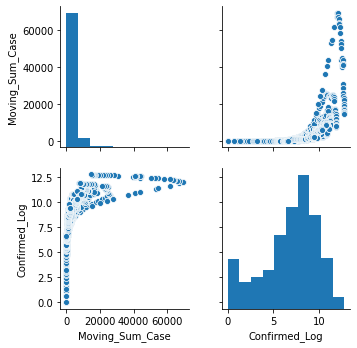

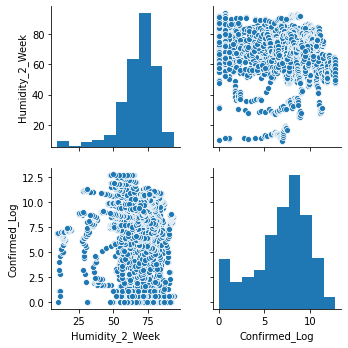

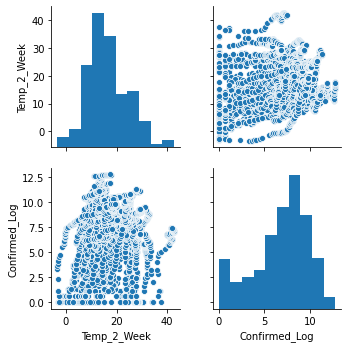

In [25]:
def draw_correlation_plot(df):
    plt.figure(figsize=(18, 12))
    ax = sns.heatmap(
        df.corr(),
        vmin=-1, 
        vmax=1, 
        center=0,
#         viridis, YlGnBu, coolwarm, RdBu_r
        cmap = "coolwarm",
#         annot=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    
    
def draw_pair_plot(df):
    print(df.columns)
    
#     for i, col in enumerate(df.columns[]):
    for i, col in enumerate(['Moving_Sum_Case', 'Humidity_2_Week', 'Temp_2_Week']):
        sns.pairplot(df[[col, 'Confirmed_Log']])
        plt.savefig('modeling-result/pair_plot_' + str(i) + '.pdf')
    
draw_pair_plot(X_train.copy())
    
    
def get_splitted_data(df, feature_list, predict_col, random=False):
    if random:
        msk = np.random.rand(len(df)) < 0.75
        train_df = df[msk].copy()
        test_df = df[~msk].copy()
    else:
        split = np.int32(0.8 * len(df))

        train_df = df[:split].copy()
        test_df = df[split:].copy()
        
#     print(len(train_df))
#     print(len(test_df))

    X_train = train_df[feature_list]
    y_train = np.int32(train_df[[predict_col]])

    X_test = test_df[feature_list]
    y_test = np.int32(test_df[predict_col])

    y_test_state = test_df[['State', predict_col]]

    return X_train, y_train, X_test, y_test, y_test_state

In [19]:
def get_significance(result_df):
    print(stats.ttest_rel(result_df.actual, result_df.prediction))

def get_time():
    return dt.today().strftime('%Y_%m_%d_%H_%M_%S')

def plot_model_accuracy(df, ml_alg):
    plt.figure(figsize=(10, 10))
    plt.plot(df['actual'], df['prediction'], 'o', color='blue', alpha=0.3)
    plt.xlabel('Actual Val')
    plt.ylabel('Prediction Val')
    plt.title(ml_alg)
    plt.savefig('modeling-result/' + ml_alg + '_' + get_time() + '.pdf')
    # plt.show()
    
def compute_best_param():
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    
    # Random search of parameters, using 5 fold cross validation, 
    # Search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = random_grid, 
                                   n_iter = 20, 
                                   cv = 5, 
                                   verbose = 2, 
                                   random_state = 42, 
                                   n_jobs = -1) 
    
    # Fit the random search model
    rf_random.fit(X_train, y_train)
    
    return str(rf_random.best_params_)

def get_model(ml_alg):
    if ml_alg=='random_forest':
        if not run_best_model:
            model = RandomForestClassifier(n_estimators = 200,
                                   max_features = 'auto',
                                   bootstrap = True)
        else:
            model = RandomForestClassifier( n_estimators = 1600, 
                                            min_samples_split = 10, 
                                            min_samples_leaf = 2, 
                                            max_features = 'auto', 
                                            max_depth = None, 
                                            bootstrap = True)
    elif ml_alg=='xgboost':
        model =  XGBClassifier()
    elif ml_alg=='svm':
        model =  svm.SVC(kernel='linear')
    elif ml_alg=='linear_svm':
        model =  LinearSVC(random_state=0, tol=1e-5)
        
    return model

# def get_error_percentage(y_test, y_pred):
#     return list(map(lambda x: 0 if x[0]==x[1] or not x[0] else 100*abs(x[0]-x[1])/x[0], zip(y_test, y_pred)))
    

def conduct_modeling(ml_alg):
    print(ml_alg + '...', end=' ')
    
    model = get_model(ml_alg)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    result_df = pd.DataFrame({
        'state': y_test_state.State,
        'actual': y_test, 
        'prediction': y_pred,
        'err_diff': abs(y_test-y_pred),
        'err_percentage': get_error_percentage(y_test, y_pred)
    }).sort_values('err_diff', ascending = False)
    
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(result_df.err_diff)))
#     print('Accuracy = {:0.2f}%.'.format(100 - 100 * np.mean(result_df.err_diff / y_test)))
    
    get_significance(result_df)

    result_df.to_csv('modeling-result/result_df.csv', index=False)
    result_df.to_csv('modeling-result/' + ml_alg + '_' + get_time() + '_df.csv', index=False)
    
    plot_model_accuracy(result_df.sort_values('actual'), ml_alg)
    
    
    # print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    ## print("Precision: ", metrics.precision_score(y_test, y_pred))
    ## print("Recall: ", metrics.recall_score(y_test, y_pred))


    if ml_alg=='random_forest':
        f = open('modeling-result/random_forest' + '_' + get_time() + '.txt', "w")
        fi = pd.DataFrame({'feature': feature_list,
                           'importance': model.feature_importances_}).sort_values('importance', ascending = False)
        f.write(str(fi))
        f.write('\n\n\n')
        
        ################################################################################################################################
        if compute_best_model:
            f.write(compute_best_param())
        ################################################################################################################################
        
        f.close()

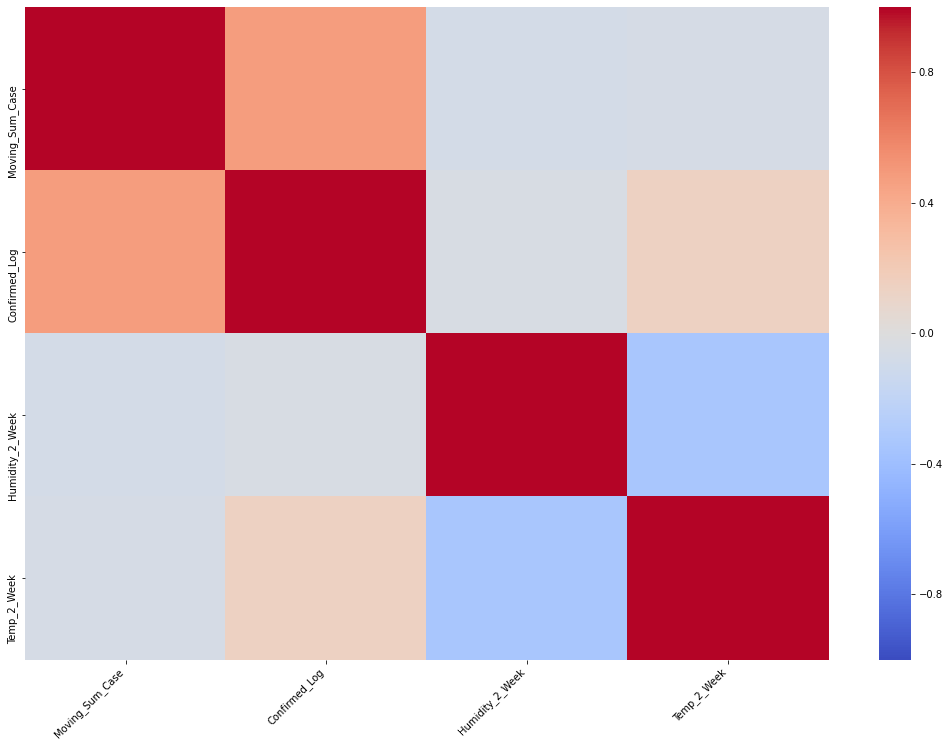

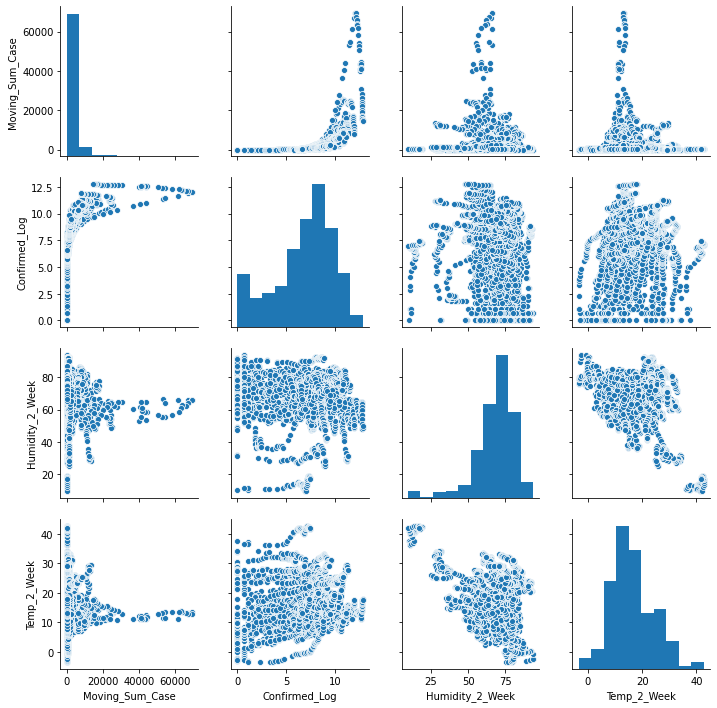

In [20]:
state_df = df
predict_col = 'Next_7_day_Moving_Average_Case'
# Next_7_day_Moving_Average_Case
# Next_3_day_Moving_Average_Case
# Next_14_day_Moving_Average_Case

################################################################################################################################
#----------- Best Result
# feature_list = ['Moving_Average_Case', 'Moving_Sum_Case', 'Increase', 'Confirmed', 'Prior_Day_Increase', 'Humidity', 'Temp_2_Week']

#----------- Make more sense, not correlated
# feature_list = ['Moving_Sum_Case', 'Confirmed_Log', 'Humidity_2_Week', 'Temp_2_Week', 'Normal_State', 'Severe_State']
feature_list = ['Moving_Sum_Case', 'Confirmed_Log', 'Humidity_2_Week', 'Temp_2_Week']




#----------- Better Result
# feature_list = ['Next_7_day_Moving_Average_Case', 'Confirmed', 'Confirmed_Log', 'Increase', 'Prior_Day_Increase',
#                 'Moving_Average_Case', 'Moving_Sum_Case', 
#                 'HeatIndex', 'Humidity', 'Humidity_3_Day', 'Humidity_Week', 'Humidity_2_Week',
#                 'Temperatue', 'Windspeed', 'Normal_State', 'Severe_State',
#                 'Temp_3_Day', 'Temp_Week', 'Temp_2_Week', 'Pop_Density', 'Weekday']
################################################################################################################################


# state_df = df.copy()[df['State'].isin(['New York', 'New Jersey', 'Illinois'])]
# state_df = df.copy()[~df['State'].isin(['New York', 'New Jersey', 'Illinois'])]
# state_df = df.copy()[~df['State'].isin(['Massachusetts'])]
################################################################################################################################
# X_train, y_train, X_test, y_test, y_test_state = get_splitted_data(state_df.sort_values('Date'), feature_list, predict_col)
X_train, y_train, X_test, y_test, y_test_state = get_splitted_data(state_df, feature_list, predict_col, random=True)
################################################################################################################################





################################################################################################################################
draw_correlation_plot(X_train.copy())
draw_pair_plot(X_train.copy())
################################################################################################################################





################################################################################################################################
# # ml_alg_list = ['random_forest', 'xgboost', 'svm', 'linear_svm']
# ml_alg_list = ['random_forest']

# # map(lambda ml_alg: conduct_modeling(ml_alg), ml_alg_list)
# for ml_alg in ml_alg_list:
#     conduct_modeling(ml_alg)
################################################################################################################################

In [14]:
# Random Forest - Optimiztion
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76
# https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
def plot_model_accuracy(model_history):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.plot(model_history.history['mean_squared_error'], color='gray')
    plt.plot(model_history.history['val_mean_squared_error'], color='blue')
    plt.title('Model Accuracy')
    plt.xlabel('# Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train Data', 'Validation Data'], loc='upper left')
    plt.show()
    
def plot_model_loss(model_history):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.plot(model_history.history['loss'], color='gray')
    plt.plot(model_history.history['val_loss'], color='blue')
    plt.title('Model Loss')
    plt.xlabel('# Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train Set', 'Validation Set'], loc='upper right')
    plt.show()

In [ ]:
def get_model(hidden_neurons):
    inputs = Input(shape=(X.shape[1],))
    dense_1 = Dense(hidden_neurons, activation='relu')(inputs)
    dense_2 = Dense(hidden_neurons, activation='relu')(dense_1)
    outputs = Dense(1, activation='sigmoid')(dense_2)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return model

In [60]:
model=get_model(200)

model_history = model.fit(x=X_train, 
                          y=y_train, 
                          validation_data=(X_validation, y_validation), 
                          epochs=5, 
                          batch_size=120)

Train on 2854 samples, validate on 714 samples
Epoch 1/50
2854/2854 [==============================] - 1s 440us/step - loss: 1234406.3102 - mean_squared_error: 1234406.3102 - val_loss: 620940.4196 - val_mean_squared_error: 620940.4196
Epoch 2/50
2854/2854 [==============================] - 0s 40us/step - loss: 1234405.9799 - mean_squared_error: 1234405.9799 - val_loss: 620940.4196 - val_mean_squared_error: 620940.4196
Epoch 3/50
2854/2854 [==============================] - 0s 40us/step - loss: 1234406.0053 - mean_squared_error: 1234406.0053 - val_loss: 620940.4196 - val_mean_squared_error: 620940.4196
Epoch 4/50
2854/2854 [==============================] - 0s 39us/step - loss: 1234405.9712 - mean_squared_error: 1234405.9712 - val_loss: 620940.4196 - val_mean_squared_error: 620940.4196
Epoch 5/50
2854/2854 [==============================] - 0s 38us/step - loss: 1234405.9707 - mean_squared_error: 1234405.9707 - val_loss: 620940.4196 - val_mean_squared_error: 620940.4196
Epoch 6/50
2854/2

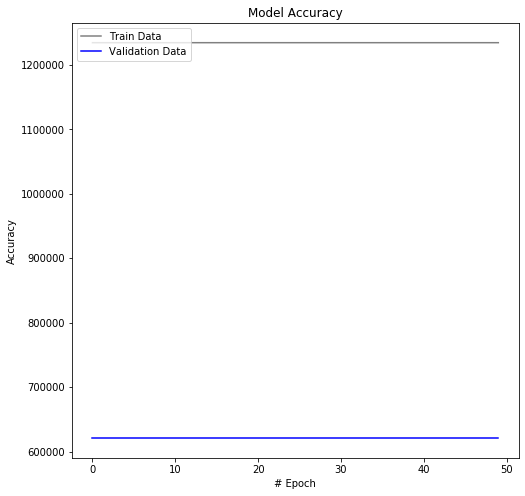

In [61]:
plot_model_accuracy(model_history)

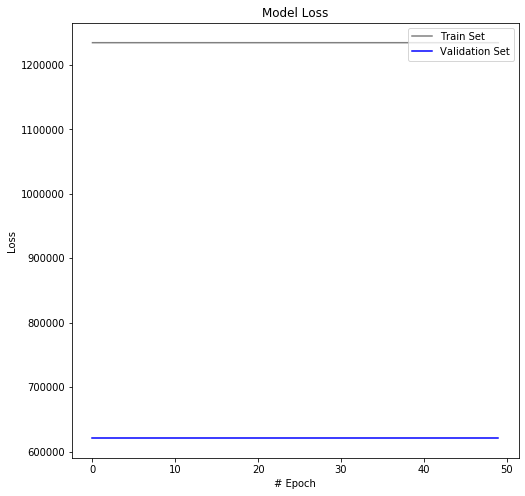

In [62]:
plot_model_loss(model_history)